In [1]:
import sys
sys.path.append('../')
import os
os.chdir('../')
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import os
import torch
import numpy as np

from torch.utils.data import DataLoader
from os.path import join as pjoin

from models.mask_transformer.transformer import MaskTransformer
from models.mask_transformer.transformer_trainer import MaskTransformerTrainer
from models.vq.model import RVQVAE

from options.train_option import TrainT2MOptions

from utils.plot_script import plot_3d_motion
from utils.motion_process import recover_from_ric
from utils.get_opt import get_opt
from utils.fixseed import fixseed
from utils.paramUtil import t2m_kinematic_chain, kit_kinematic_chain

from data.t2m_dataset import Text2MotionDataset
from motion_loaders.dataset_motion_loader import get_dataset_motion_loader
from models.t2m_eval_wrapper import EvaluatorModelWrapper
from exit.utils import visualize_2motions

/home/epinyoan/miniconda3/envs/momask/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from options.train_option import TrainT2MOptions
parser = TrainT2MOptions()
opt = parser.parse(is_mock=True)
opt.name

------------ Options -------------
batch_size: 64
checkpoints_dir: ./log/t2m
cond_drop_prob: 0.1
dataset_name: t2m
dropout: 0.2
eval_every_e: 10
ff_size: 1024
force_mask: False
gamma: 0.1
gpu_id: -1
gumbel_sample: False
is_continue: False
is_train: True
latent_dim: 384
log_every: 50
lr: 0.0002
max_epoch: 500
max_motion_length: 196
milestones: [50000]
n_heads: 6
n_layers: 8
name: 2024-05-22-20-06-48_t2m_nlayer8_nhead6_ld384_ff1024_cdp0.1_rvq6ns
save_latest: 500
seed: 3407
share_weight: False
trans: official
unit_length: 4
vq_name: rvq_nq1_dc512_nc512
warm_up_iter: 2000
-------------- End ----------------


'2024-05-22-20-06-48_t2m_nlayer8_nhead6_ld384_ff1024_cdp0.1_rvq6ns'

In [4]:
opt.data_root = './dataset/HumanML3D'
opt.motion_dir = pjoin(opt.data_root, 'new_joint_vecs')
opt.joints_num = 22
opt.max_motion_len = 55
dim_pose = 263
radius = 4
fps = 20
kinematic_chain = t2m_kinematic_chain
dataset_opt_path = './checkpoints/t2m/Comp_v6_KLD005/opt.txt'


In [5]:
opt.vq_name = 'rvq_nq6_dc512_nc512_noshare_qdp0.2'
vq_opt = get_opt(f'/home/epinyoan/git/momask-codes/checkpoints/t2m/{opt.vq_name}/opt.txt', 'cuda')
vq_model = RVQVAE(vq_opt,
                dim_pose,
                vq_opt.nb_code,
                vq_opt.code_dim,
                vq_opt.output_emb_width,
                vq_opt.down_t,
                vq_opt.stride_t,
                vq_opt.width,
                vq_opt.depth,
                vq_opt.dilation_growth_rate,
                vq_opt.vq_act,
                vq_opt.vq_norm)
ckpt = torch.load(pjoin(vq_opt.checkpoints_dir, vq_opt.dataset_name, vq_opt.name, 'model', 'net_best_fid.tar'),
                        map_location='cpu')
model_key = 'vq_model' if 'vq_model' in ckpt else 'net'
vq_model.load_state_dict(ckpt[model_key])
print(f'Loading VQ Model {opt.vq_name}')

Reading /home/epinyoan/git/momask-codes/checkpoints/t2m/rvq_nq6_dc512_nc512_noshare_qdp0.2/opt.txt


Loading VQ Model rvq_nq6_dc512_nc512_noshare_qdp0.2


In [6]:
opt.log_dir = pjoin('./log/t2m/', opt.dataset_name, opt.name)
opt.device = 'cuda' #torch.device("cpu" if opt.gpu_id == -1 else "cuda:" + str(opt.gpu_id))
opt.text_dir = pjoin(opt.data_root, 'texts')
opt.num_tokens = vq_opt.nb_code
clip_version = 'ViT-B/32'
# opt.trans = 't2mgpt'
opt.trans = 'official'

t2m_transformer = MaskTransformer(code_dim=vq_opt.code_dim,
                                      cond_mode='text',
                                      latent_dim=opt.latent_dim,
                                      ff_size=opt.ff_size,
                                      num_layers=opt.n_layers,
                                      num_heads=opt.n_heads,
                                      dropout=opt.dropout,
                                      clip_dim=512,
                                      cond_drop_prob=opt.cond_drop_prob,
                                      clip_version=clip_version,
                                      opt=opt)
# t2m_transformer.load_and_freeze_token_emb(vq_model.quantizer_upper.codebooks[0], vq_model.quantizer_lower.codebooks[1])

latent_dim: 384, ff_size: 1024, nlayers: 8, nheads: 6, dropout: 0.2
Loading CLIP...


In [7]:
model_dir = '/home/epinyoan/git/momask-codes/log/t2m/t2m/2024-02-14-14-27-29_8_GPT_officialTrans_2iterPrdictEnd/model/net_best_fid.tar'
checkpoint = torch.load(model_dir, map_location='cuda')
missing_keys, unexpected_keys = t2m_transformer.load_state_dict(checkpoint['t2m_transformer'], strict=False)

In [ ]:
mean = np.load(pjoin('./checkpoints/', opt.dataset_name, opt.vq_name, 'meta', 'mean.npy'))
std = np.load(pjoin('./checkpoints/', opt.dataset_name, opt.vq_name, 'meta', 'std.npy'))

train_split_file = pjoin(opt.data_root, 'train.txt')
val_split_file = pjoin(opt.data_root, 'val.txt')

train_dataset = Text2MotionDataset(opt, mean, std, train_split_file)
val_dataset = Text2MotionDataset(opt, mean, std, val_split_file)

train_loader = DataLoader(train_dataset, batch_size=opt.batch_size, num_workers=4, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=opt.batch_size, num_workers=4, shuffle=True, drop_last=True)

eval_val_loader, _ = get_dataset_motion_loader(dataset_opt_path, 32, 'test', device=opt.device)

wrapper_opt = get_opt(dataset_opt_path, torch.device('cuda'))
eval_wrapper = EvaluatorModelWrapper(wrapper_opt)


In [9]:
t2m_transformer.to(opt.device)
vq_model.to(opt.device)
''

''

In [10]:
from models.mask_transformer.transformer import ResidualTransformer
def load_res_model(res_opt):
    res_opt.num_quantizers = vq_opt.num_quantizers
    res_opt.num_tokens = vq_opt.nb_code
    res_transformer = ResidualTransformer(code_dim=vq_opt.code_dim,
                                            cond_mode='text',
                                            latent_dim=res_opt.latent_dim,
                                            ff_size=res_opt.ff_size,
                                            num_layers=res_opt.n_layers,
                                            num_heads=res_opt.n_heads,
                                            dropout=res_opt.dropout,
                                            clip_dim=512,
                                            shared_codebook=vq_opt.shared_codebook,
                                            cond_drop_prob=res_opt.cond_drop_prob,
                                            # codebook=vq_model.quantizer.codebooks[0] if opt.fix_token_emb else None,
                                            share_weight=res_opt.share_weight,
                                            clip_version=clip_version,
                                            opt=res_opt)

    ckpt = torch.load(pjoin(res_opt.checkpoints_dir, res_opt.dataset_name, res_opt.name, 'model', 'net_best_fid.tar'),
                      map_location=opt.device)
    missing_keys, unexpected_keys = res_transformer.load_state_dict(ckpt['res_transformer'], strict=False)
    assert len(unexpected_keys) == 0
    assert all([k.startswith('clip_model.') for k in missing_keys])
    print(f'Loading Residual Transformer {res_opt.name} from epoch {ckpt["ep"]}!')
    return res_transformer
res_opt = get_opt('/home/epinyoan/git/momask-codes/checkpoints/t2m/tres_nlayer8_ld384_ff1024_rvq6ns_cdp0.2_sw/opt.txt', device=opt.device)
res_model = load_res_model(res_opt).cuda()

Reading /home/epinyoan/git/momask-codes/checkpoints/t2m/tres_nlayer8_ld384_ff1024_rvq6ns_cdp0.2_sw/opt.txt
latent_dim: 384, ff_size: 1024, nlayers: 8, nheads: 6, dropout: 0.2
Loading CLIP...
Loading Residual Transformer tres_nlayer8_ld384_ff1024_rvq6ns_cdp0.2_sw from epoch 440!


In [11]:
t2m_transformer.eval()
vq_model.eval()
''

''

### Text to Motion (from dataset)

In [ ]:
__break__ = False
while __break__ is False:
    for word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token in eval_val_loader:
    # for clip_text, pose, m_length in train_loader:
        for i, text in enumerate(clip_text):
            # if True: #'cartwheel' in text:
            # if 'a person walks forward then turns completely around and does a cartwheel.' in text:
            # if 'a person who is standing moves his body and shoulders slightly to the left and returns to his original position.' in text:
            # if 'person carefully kneels down. first with right leg, then with the left one.' in text:
            # if 'a person walks forward then turns completely around and does a cartwheel.' in text:
            # if 'a person with their arms out from their sides, walks to the left trying to balance.' in text:
            # if 'a person walks forward, then is pushed to their left and then returns to walking in the line they were.' in text:
            # if 'the person crouches and walks forward.' in text:
            if len(text) < 100:
                __break__ = True
                print(i, m_length[i], text)
                break
        if __break__:
            break
m_length = m_length.cuda()
base_pose = pose.cuda()

''

In [157]:
word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token = next(iter(eval_val_loader))
# clip_text, pose, m_length = next(iter(train_loader))
m_length = m_length.cuda()
base_pose = pose.cuda()
for i in range(len(clip_text)):
    # if len(clip_text[i]) < 100 and m_length[i]>=180: # 
    print(i, m_length[i].cpu().numpy(), clip_text[i])

0 124 a person takes two steps forward leading with their right foot rotates on their left foot 180 degrees and takes two steps back.
1 196 standing on their right foot, a person flexes their knee forward and back and side to side, toward the right first and then the left.
2 188 the person slides to their right 3 times, slides to their left 4 times, and slides to their left 2 times, ending at their original position.
3 196 person squats down to their knees, and then begins to crawl around in random directions. seems to be playful
4 144 a person walks diagonally to the left, bends over and picks up a few items, then continues walking
5 196 a man sits down on the ground cross-legged and throws an object with his right hand.
6 84 a person who is standing with his hands at his sides quickly runs forward and stops.
7 64 the person steps back on their left leg before pitching a baseball forward.
8 172 person was standing and straddled a chair and sat down.
9 196 a man paces back and forth al

In [15]:
# 196 a person throws a shotput.
# the person crouches and walks forward.


In [149]:
i=13
clip_text[i]

'a person stands up from a sit down position, then sits back down.'

In [ ]:
time_steps = 3
cond_scale = 4
mids = t2m_transformer.generate(clip_text, m_length, time_steps, cond_scale, temperature=1) # , temp=code_idx[..., 0]
mids, pred_len = t2m_transformer.pad_when_end(mids)
mids = res_model.generate(mids, clip_text, pred_len, temperature=1, cond_scale=5)
# mids =  mids.unsqueeze_(-1)
pred_motions = vq_model.forward_decoder(mids)[:, :196]

k = i
x = pred_motions[k].detach().cpu().numpy()
l = pred_len[k]*4 # m_length[k] #
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, 't2m', l, base_pose[k].cpu().numpy())
pred_len[k]*4, clip_text[k]

In [ ]:
pred_probs.shape

(1, 50)

### Text to Motion (from Text)

In [14]:
repeat = 100
# a person appears to be ding jump rope until they fail
# walking in a circle with hands up.
# 'a person starts walking then starts leaping counterclockwise' # momask fails at 156
# a person tip toeing in an l shape figure to the right. # momask not bad

# [Momask Not fail]
# A man starts off with both arms extended out by his sides. He then brings his arms down to his body and claps his hands together. After this, he walks down and to the right where he proceeds to sit on a seat.
# [Cannot replicate]
# A person ducks down to walk underneath a fence in front of them. Walk around something, then turn left again to climb up a something
# [Momask Not fail]
# the person slides to their right, slides to their left, and back forth, trying to move away  from something in a game
clip_text1 = ['a person walks in a zig zag motion then comes to a halt'] * repeat
m_length1 = torch.tensor([1]*repeat).cuda()
mids = t2m_transformer.generate(clip_text1, m_length1, timesteps=3, cond_scale=4, temperature=1) # , temp=code_idx[..., 0]
mids, pred_len = t2m_transformer.pad_when_end(mids)
mids = res_model.generate(mids, clip_text1, pred_len, temperature=1, cond_scale=5)
pred_motions = vq_model.forward_decoder(mids)[:, :196]

In [290]:
# for i in range(len(pred_len)):
#     # if pred_len[i] == 39:
#     print(i, pred_len[i].cpu().detach().item())

In [ ]:
i = 1
x = pred_motions[i].detach().cpu().numpy()
l = pred_len[i]*4 # m_length[k] #
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, 't2m', l)
pred_len[i]*4, clip_text1[i]

In [272]:
# i = 4
# motion = pred_motions[i][: (pred_len[i]*4)].cpu().detach().numpy()
np.save('./BAMM_a_person_starts_walking_then_starts_leaping_counterclockwise._156.npy.npy', pred_motions.cpu().detach())

In [24]:
motion = np.load('crouch_walk_together_156.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'crouch_walk_together_156.npy'

In [25]:
x = motion
l = motion.shape[0]
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, 't2m', l)

NameError: name 'motion' is not defined

### DELETE ME

In [ ]:
__break__ = False
while __break__ is False:
    for word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token in eval_val_loader:
        for i, text in enumerate(clip_text):
            # if 'a person, whose hands is swaying front to back, is walking in a counter-clockwise circle while bringing their knees up as they walk.' in text:
            #     __break__ = True
            if m_length[i] >= 196:
                print(i, m_length[i]/4, text)
                __break__ = True
                # break
        if __break__:
            break

3 tensor(49.) a man walks in a circle for 10 seconds to stretch his legs after sitting for an extended period of time.
7 tensor(49.) a person walks forward carefully placing one foot directly in front of the other foot.
13 tensor(49.) a person walks forward, turns, then sits, then stands and walks back
15 tensor(49.) a person aggressively grabbing holding something before drinking it.
19 tensor(49.) a person is leaning forward and reaching for something.
23 tensor(49.) the person has washing his right arm.
28 tensor(49.) person stands there and looks around.


In [ ]:
# txt = ['the person is stretching arms out.']
k = 1
txt = [clip_text[k]]
input_len = torch.tensor([49]).cuda()
mids = t2m_transformer.generate(txt, input_len, timesteps = 3, cond_scale = 4, temperature=1) # , temp=code_idx[..., 0]
mids, pred_len = t2m_transformer.pad_when_end(mids)
mids = res_model.generate(mids, txt, pred_len, temperature=1, cond_scale=5)
pred_motions = vq_model.forward_decoder(mids)[:, :196]

x = pred_motions[0].detach().cpu().numpy()
l = pred_len[0]*4 #pred_len[k]
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, 't2m', l, pose[k].cpu().numpy())

### Edit (Generated Base)

In [ ]:
time_steps = 3
cond_scale = 4
# base_text = ['a figure walks forward']
base_text = ['a person walks forward.']
cond_tokens = t2m_transformer.pad_id * torch.ones((1, 50), dtype=torch.long).cuda()
cond_tokens = cond_tokens.scatter_(-1, torch.tensor([[49]]).cuda(), t2m_transformer.end_id).long() # add end token to tell model where to stop generating
index_motion = t2m_transformer.edit2(base_text, cond_tokens)
# index_motion = t2m_transformer.generate(base_text, m_length, time_steps, cond_scale, temperature=1)
index_motion, pred_len = t2m_transformer.pad_when_end(index_motion)
index_motion = res_model.generate(index_motion, base_text, pred_len, temperature=1, cond_scale=5)
mids =  mids.unsqueeze_(-1)
pred_motions = vq_model.forward_decoder(index_motion)[:, :196]

k = 0
x = pred_motions[k].detach().cpu().numpy()
l = pred_len[k]*4 #pred_len[k]
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, 't2m', l)

In [ ]:
gen_text = ['a person jump in place.']
left = int(pred_len[k]/4)
right = int(pred_len[k]-left-4)
cond_tokens = index_motion.clone()
cond_tokens[k, :left] = t2m_transformer.pad_id
cond_tokens[k, right:] = t2m_transformer.pad_id
cond_tokens = cond_tokens[..., 0]
cond_tokens = cond_tokens.scatter_(-1, pred_len[..., None], t2m_transformer.end_id).long() # add end token to tell model where to stop generating
mids = t2m_transformer.edit2(gen_text, cond_tokens)
mids[k, pred_len[k]:] = t2m_transformer.pad_id
mids = res_model.generate(mids, gen_text, pred_len, temperature=1, cond_scale=5)
pred_motions = vq_model.forward_decoder(mids)[:, :196]

x = pred_motions[k].detach().cpu().numpy()
l = pred_len[k] * 4
caption = text[k]
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, 't2m', l)

In [ ]:
# np.save('outpainting.npy', x)
# x = np.load('./outpainting.npy')
# l = x.shape[0]
# caption = text[k]
# visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, 't2m', l)

### Edit (Test Set Base)

In [ ]:
__break__ = False
while __break__ is False:
    for word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token in eval_val_loader:
        for i, text in enumerate(clip_text):
            # if True: #'cartwheel' in text:
            # if 'a person walks forward then turns completely around and does a cartwheel.' in text:
            # if 'a person who is standing moves his body and shoulders slightly to the left and returns to his original position.' in text:
            # if 'person carefully kneels down. first with right leg, then with the left one.' in text:
            # if 'a person walks forward then turns completely around and does a cartwheel.' in text:
            # if 'a person with their arms out from their sides, walks to the left trying to balance.' in text:
            # if 'a person walks forward, then is pushed to their left and then returns to walking in the line they were.' in text:
            if 'walk' in text:
                __break__ = True
                print(i, m_length[i], text)
                break
        if __break__:
            break
m_length = m_length[i:i+1].cuda()
base_pose = pose[i:i+1].cuda()

''

0 tensor(196) a person walks up to shake with their left hand, turns slightly left to shake again, and turns left again to shake for a final time.


''

In [ ]:
gen_text = ['A person sits down.']
bs, seq = pose.shape[:2]

# cond prefix tokens
# half_l = int(m_length/2) # condition by first half
# token_length = (m_length/4).long() # downsampling 4 times
# cond_tokens = t2m_transformer.pad_id * torch.ones((1, 50), dtype=torch.long).cuda()

# index_motion, _ = vq_model.encode(base_pose[:, :half_l].cuda())
# index_motion = index_motion[..., 0]

# cond_tokens[:, :index_motion.shape[1]] = index_motion
# cond_tokens = cond_tokens.scatter_(-1, token_length[..., None], t2m_transformer.end_id).long() # add end token to tell model where to stop generating


# cond outpainting
tokens = t2m_transformer.pad_id * torch.ones((bs, 50), dtype=torch.long).cuda()
m_token_length = torch.ceil((m_length)/4).int().cpu().numpy()
m_token_length_init = (m_token_length * .25).astype(int)
m_length_init = (m_length * .25).int()

k=0
l = m_length_init[k]
l_token = m_token_length_init[k]

index_motion, _ = vq_model.encode(pose[k:k+1, l:m_length[k]-l].cuda())
index_motion = index_motion[..., 0]
tokens[k, l_token: l_token+index_motion.shape[1]] = index_motion[0]
cond_tokens = tokens[k:k+1]


mids = t2m_transformer.edit2(gen_text, cond_tokens)
mids, pred_len = t2m_transformer.pad_when_end(mids)
mids = res_model.generate(mids, gen_text, pred_len, temperature=1, cond_scale=5)
# mids =  mids.unsqueeze_(-1)
pred_motions = vq_model.forward_decoder(mids)[:, :196]

In [ ]:
k = 0
x = pred_motions[k].detach().cpu().numpy()
l = m_length[k]
caption = text[k]
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, 't2m', l, base_pose[i].detach().cpu().numpy())

### Longrange

In [ ]:
time_steps = 3
cond_scale = 4
clip_text = ['a person is doing a salsa dance moving their legs and arms.',
             'a figure sits on the chair.',
            #  'a person squatting raises both their arms above their head.',
             'a man jump forward.',
             'a person punches as if they are boxing.',
             'A woman crawl around.',
             'A person is running forward in a long line.'
             ]
m_length = torch.tensor([0]).cuda()
mids = t2m_transformer.generate(clip_text, m_length, time_steps, cond_scale, temperature=1) # , temp=code_idx[..., 0]
mids, pred_len = t2m_transformer.pad_when_end(mids)
mids = res_model.generate(mids, clip_text, pred_len, temperature=1, cond_scale=5)
# mids =  mids.unsqueeze_(-1)
pred_motions = vq_model.forward_decoder(mids)[:, :196]

k = 0
x = pred_motions[k].detach().cpu().numpy()
l = pred_len[k]*4 #pred_len[k]
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, 't2m', l)

In [ ]:
num_transition_token = 2
b = mids.shape[0]

half_token_length = (pred_len/2).int()
idx_full_len = half_token_length >= 24
half_token_length[idx_full_len] = half_token_length[idx_full_len] - 1
tokens = -1 * torch.ones((b-1, 50), dtype=torch.long).cuda()
transition_train_length = []
for i in range(b-1):
    i_index_motion = mids[i ,: , 0]
    i1_index_motion = mids[i+1 ,: , 0]

    left_end = half_token_length[i]
    right_start = left_end + num_transition_token
    end = right_start + half_token_length[i+1]

    tokens[i, :left_end] = i_index_motion[pred_len[i]-left_end: pred_len[i]]
    tokens[i, left_end:right_start] = t2m_transformer.pad_id
    tokens[i, right_start:end] = i1_index_motion[:half_token_length[i+1]]
    transition_train_length.append(end)
transition_train_length = torch.tensor(transition_train_length).to(mids.device).long()
tokens = tokens.scatter_(-1, transition_train_length[..., None], t2m_transformer.end_id).long() # add end token to tell model where to stop generating
inpainting_mask = tokens == t2m_transformer.pad_id
tokens[tokens == -1] = t2m_transformer.pad_id
inpaint_index = t2m_transformer.edit2(None, tokens)

# residual 
all_tokens = []
for i in range(b-1):
    all_tokens.append(mids[i, :pred_len[i]])

    inpaint_all = inpaint_index[i, inpainting_mask[i]].unsqueeze(-1)
    inpaint_all = torch.nn.functional.pad(inpaint_all,  (0, 5),  value = -1)
    all_tokens.append(inpaint_all)
all_tokens.append(mids[-1, :pred_len[-1]])
all_tokens = torch.cat(all_tokens).unsqueeze(0)

# 

In [ ]:
pred_motions = vq_model.forward_decoder(all_tokens)
k = 0
x = pred_motions[k].detach().cpu().numpy()[:1000]
l = pred_motions.shape[1]
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, 't2m', l, save_path='./longrange.html')

In [ ]:
# np.save('longrange.npy', pred_motions[0].detach().cpu().numpy())
# clip_text, pred_len*4

### Eval
For testing load the correct model

In [ ]:
from utils.eval_t2m import evaluation_mask_transformer
class LoggerWriterMock:
    def __init__(self):
        self.info
    def info(self, *args):
        print(*args)
    def add_scalar(self, *args):
        print(*args)
    def add_video(self, *args):
        print(*args)
logger = LoggerWriterMock()
best_fid, best_div, best_top1, best_top2, best_top3, best_matching, writer = evaluation_mask_transformer(
        'opt.save_root', eval_val_loader, t2m_transformer, vq_model, logger, 0,
        best_fid=100, best_div=100,
        best_top1=0, best_top2=0, best_top3=0,
        best_matching=100, eval_wrapper=eval_wrapper,
        plot_func=lambda x:x, save_ckpt=False, save_anim=False
    )

  0%|          | 0/145 [00:00<?, ?it/s]

100%|██████████| 145/145 [01:45<00:00,  1.37it/s]

--> 	 Eva. Ep 0 :, FID. 0.0799, Diversity Real. 9.5846, Diversity. 9.9658, R_precision_real. [0.51551724 0.70603448 0.79892241], R_precision. [0.50581897 0.68771552 0.78599138], matching_score_real. 2.978284403373455, matching_score_pred. 3.0599816914262443
./Test/FID 0.0799292176316726 0
./Test/Diversity 9.965841 0
./Test/top1 0.5058189655172414 0
./Test/top2 0.6877155172413794 0
./Test/top3 0.7859913793103448 0
./Test/matching_score 3.0599816914262443 0
--> --> 	 FID Improved from 100.00000 to 0.07993 !!!
--> --> 	 matching_score Improved from 100.00000 to 3.05998 !!!
--> --> 	 Diversity Improved from 100.00000 to 9.96584 !!!
--> --> 	 Top1 Improved from 0.0000 to 0.5058 !!!
--> --> 	 Top2 Improved from 0.0000 to 0.6877 !!!
--> --> 	 Top3 Improved from 0.0000 to 0.7860 !!!


### Length Estimator

In [ ]:
from models.len_predictor_modules import MotionLenEstimatorBiGRU
from utils.word_vectorizer import WordVectorizer, POS_enumerator
from torch.distributions.categorical import Categorical
unit_length = 4
dim_word = 300
dim_pos_ohot = len(POS_enumerator)
num_classes = 200 // unit_length
estimator = MotionLenEstimatorBiGRU(dim_word, dim_pos_ohot, 512, num_classes)

cp = '/home/epinyoan/git/momask-codes/checkpoints/t2m/length_est_bigru/model/latest.tar'
checkpoints = torch.load(cp, map_location='cpu')
estimator.load_state_dict(checkpoints['estimator'], strict=True)
estimator.cuda()
estimator.eval()
softmax = torch.nn.Softmax(-1)

def m_len_estimator(word_embeddings, pos_one_hots, sent_len):
    pred_probs = estimator(word_embeddings.cuda().float(), pos_one_hots.cuda().float(), sent_len).detach()
    pred_probs = softmax(pred_probs)
    pred_tok_len = pred_probs.argsort(dim=-1, descending=True)[:, :5][..., 0]
    # pred_tok_len = Categorical(pred_probs).sample()  # (b, seqlen)
    # pred_tok_len = torch.multinomial(pred_probs, 1, replacement=True).squeeze()
    return pred_tok_len # token

In [ ]:
from tqdm import tqdm 
len_estimate_type = '' #'BAMM' 
eval_val_loader, _ = get_dataset_motion_loader(dataset_opt_path, 1024, 'test', device=opt.device, drop_last=False, shuffle=False)
all_diff_len = None
for word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token in tqdm(eval_val_loader):
    if len_estimate_type == 'BAMM':
        mids = t2m_transformer.generate(clip_text, m_length.cuda(), timesteps = 3, cond_scale = 4, temperature=1) # , temp=code_idx[..., 0]
        mids, pred_len = t2m_transformer.pad_when_end(mids)
        pred_len = pred_len * 4
    else:
        pred_len = m_len_estimator(word_embeddings, pos_one_hots, sent_len) * 4
    diff_len = pred_len - m_length.cuda()
    if all_diff_len is None:
        all_diff_len = diff_len
    else:
        all_diff_len = torch.cat([all_diff_len, diff_len])
all_diff_len
(all_diff_len == 0).sum(), (all_diff_len != 0).sum()

Reading ./checkpoints/t2m/Comp_v6_KLD005/opt.txt
Loading dataset t2m ...


  0%|          | 0/4384 [00:00<?, ?it/s]

100%|██████████| 4384/4384 [00:01<00:00, 2655.14it/s]


Pointer Pointing at 0
Ground Truth Dataset Loading Completed!!!


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


(tensor(1232, device='cuda:0'), tensor(3416, device='cuda:0'))

In [ ]:
# (tensor(530, device='cuda:0'), tensor(3566, device='cuda:0'))
BAMM_all_diff_len = all_diff_len

In [ ]:
# (tensor(1753, device='cuda:0'), tensor(2343, device='cuda:0'))
T2M_all_diff_len = all_diff_len

/home/epinyoan/miniconda3/envs/momask/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/home/epinyoan/miniconda3/envs/momask/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



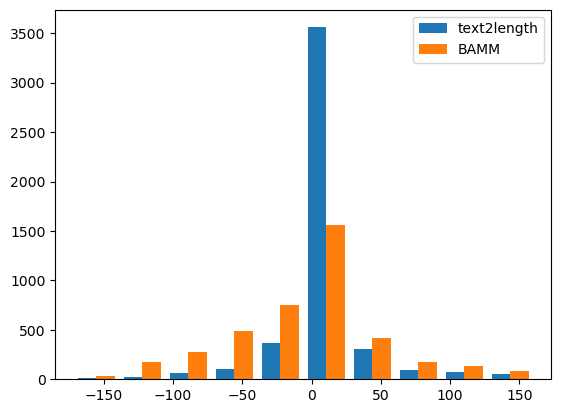

In [ ]:
plt.hist([T2M_all_diff_len.detach().cpu().numpy(), 
            BAMM_all_diff_len.detach().cpu().numpy()], 
            label=['text2length', 'BAMM'])
plt.legend(loc='upper right')
plt.show()

### Text2Length custom prompt

In [ ]:
from utils.word_vectorizer import WordVectorizer
w_vectorizer = WordVectorizer('./glove', 'our_vab')

In [ ]:
clip_text = ['a person dances with one leg']
tokens = ['sos/OTHER', 'a/DET', 'person/NOUN', 'dances/VERB', 'with/ADP', 'one/NUM', 'leg/NOUN', 'eos/OTHER']
tokens = tokens + ['unk/OTHER'] * (22 - len(tokens))

pos_one_hots = []
word_embeddings = []
for token in tokens:
    word_emb, pos_oh = w_vectorizer[token]
    pos_one_hots.append(pos_oh[None, :])
    word_embeddings.append(word_emb[None, :])
pos_one_hots = np.concatenate(pos_one_hots, axis=0)
pos_one_hots = torch.from_numpy(pos_one_hots[np.newaxis, ...])
word_embeddings = np.concatenate(word_embeddings, axis=0)
word_embeddings = torch.from_numpy(word_embeddings[np.newaxis, ...])

In [ ]:
prob = estimator(word_embeddings.cuda().float(), pos_one_hots.cuda().float(), torch.tensor([len(clip_text)])).detach()
prob = softmax(prob)
prob = prob.detach().cpu().numpy()

plt.bar(np.arange(prob.shape[1]), prob[0])

### BAMM len Single Prompt

In [ ]:
eval_val_loader, _ = get_dataset_motion_loader(dataset_opt_path, 32, 'test', device=opt.device, drop_last=False, shuffle=True)

Reading ./checkpoints/t2m/Comp_v6_KLD005/opt.txt
Loading dataset t2m ...


  0%|          | 0/4384 [00:00<?, ?it/s]

100%|██████████| 4384/4384 [00:01<00:00, 2366.98it/s]

Pointer Pointing at 0
Ground Truth Dataset Loading Completed!!!


In [ ]:
__break__ = False
while __break__ is False:
    for word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token in eval_val_loader:
        for i, text in enumerate(clip_text):
            # if 'jump' in text:
            __break__ = True
            print(i, m_length[i]/4, text)
                # break
        if __break__:
            break

0 tensor(42.) a person takes a step forward, turns around and walks back behind them, then turns around to face their front.
1 tensor(49.) a person moves forward then left while making the motion of shaking the hands with the right arm, both arms and then the right arm again.
2 tensor(24.) a man walks forward turns to the right and then walks back in the direct he came.
3 tensor(16.) a person steps back with his left leg, dragging his right leg on the ground.
4 tensor(23.) a person sways to swing their right foot followed by their left foot.
5 tensor(29.) a person with their knees on the ground and their hands, gets up.
6 tensor(12.) a person drives forward to the right and then curves to the left.
7 tensor(35.) a man walks forward before stumbling backwards and the continues walking forward.
8 tensor(48.) man man jumps up throws a ball high, then throws another lowe.
9 tensor(42.) a person raises their arm and takes a small step forward
10 tensor(48.) the person is walking forward and

(array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.02, 0.06, 0.15, 0.43, 0.16, 0.14, 0.03, 0.  ,
        0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

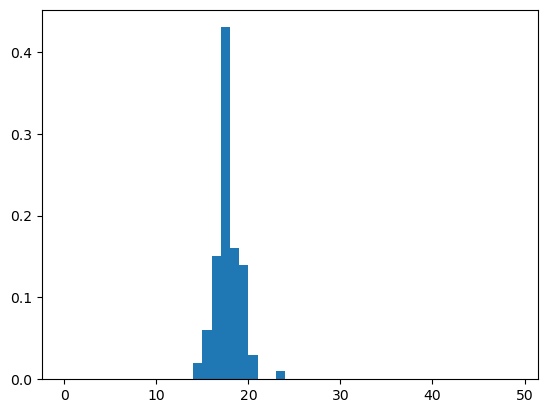

In [ ]:
i = 9
mids = t2m_transformer.generate([clip_text[i]]*100, m_length.cuda(), timesteps = 3, cond_scale = 4, temperature=1) # , temp=code_idx[..., 0]
mids, pred_len = t2m_transformer.pad_when_end(mids)
# plt.bar(bins[:-1], counts/1e3, label="Bars 1") # , color="blue"
density, bins = np.histogram(pred_len.detach().cpu().numpy(), bins=np.arange(50))
unity_density = density / density.sum()
plt.hist(bins[:-1], bins, weights=unity_density)